# Deplatforming and Misinformation: Efficacy of Twitter's January 2021 User Suspensions

## Introduction

This analysis builds on the study, *Post-January 6th deplatforming reduced the reach of misinformation on Twitter* (McCabe et al. 2024), which examined Twitter's large-scale account suspensions following the January 6th, 2021 insurrection. Noting the significant role misinformation and conspiracy theories played, Twitter and other social media platforms implemented sweeping account suspensions to prevent their spread.

The goal of this project is to replicate and extend the findings of McCabe et al. using an anonymized replication dataset provided by the authors. I aim to further susbtantiate their conclusions to gauge the actual efficacy of Twitter's post-January 6th user suspensions. By doing so, I hope to improve the understanding of how social media platforms can mitigate the spread of misinformation and its impact on public discourse.

### Background and Context

The original research team compiled a pool of over 500,000 active Twitter users that could be cross-verified with a voter registration database, then assembled a dataset containing all of these users' activity between 2019 and 2021. 

Using multiple pre-curated lists of websites known to be sources of misinformation, the researchers focused specifically on tweets and retweets containing links to these websites.

Notes
- Aggregated Twitter data from late 2019 through 2021, focusing on URLs identified as misinformation
- Classified users into categories based on their activity levels and misinformation spread
- Used Difference-in-Differences (DiD) to measure the causal effect of deploatforming on misinformation spread

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, date
import matplotlib.pyplot as plt
import matplotlib_venn as venn
import matplotlib.dates as mdates
import seaborn as sns
import re
import json
import warnings
import statsmodels.api as sm

warnings.filterwarnings(action="ignore", category=pd.errors.SettingWithCopyWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)
warnings.filterwarnings(action="ignore", category=RuntimeWarning)
warnings.filterwarnings(action="ignore", category=DeprecationWarning)

## Data Preparation and Organization

In [ ]:
# load data
mccabe = mccabe = pd.read_csv(
    "mccabe-public-data.csv", on_bad_lines="skip"
).reset_index(names=["ID"])
mccabe["group"] = mccabe["group"]
mccabe["date"] = pd.to_datetime(mccabe["date"], format="%Y-%m-%d")

### De-aggregating the data

To protect users' privacy, the replication data is available in an anonymized, aggregated format. The researchers divided the users into overlapping categories based on their activity levels and misinformation spread, then supplied the observed (mostly) daily counts for each group. 

Select Groups:
| Name | Group | Description |
|------|-------|-------------|
| FNS | misinformation sharers | users who share at least 1 URL with misinformation |
| DU | suspended users | users removed between January 6th and January 12th |
| HA | high activity | users who sent at least 3,200 tweets during a six-week collection interval between 2018 and April 2020 |
| MA | medium activity | the most active 500,000 users who didn't meet the high activity threshold |
| LA | low activity | all users who didn't meet the high or medium activity thresholds |
| A | Trump-only followers | non-suspended misinformation sharers who follow Trump but no other deplatformed users |
| B | deplatformed followers | non-suspended misinformation sharers who follow at least one deplatformed user (can include Trump) |
| D | 4+ deplatformed followers | non-suspended misinformation sharers who follow at least four deplatformed users (can include Trump) |
| F | not deplatformed followers | non-suspended misinformation sharers who do not follow any deplatformed users |

I used some probability rules to reorganize the data into a more usable (mutually exclusive) format.

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 10))

v = venn.venn2(subsets=(4, 6, 3), set_labels=(' Group A ', ' Group B '), set_colors=('yellow', 'blue'), alpha=0.5, ax=ax[0])
v.get_label_by_id('10').set_text('')
v.get_label_by_id('01').set_text('')
v.get_label_by_id('11').set_text('')
v.get_patch_by_id('11').set_color('green')

w = venn.venn2(subsets=(4, 6, 3), set_labels=(' Group D ', ' Group B '), set_colors=('red', 'blue'), alpha=0.5, ax=ax[1])
w.get_label_by_id('10').set_text('')
w.get_label_by_id('01').set_text('')
w.get_label_by_id('11').set_text('')
w.get_patch_by_id('11').set_color('purple')

x = venn.venn2(subsets=(4, 4, 0), set_labels=(' Group A ', ' Group D '), set_colors=('yellow', 'red'), alpha=0.5, ax=ax[2])
x.get_label_by_id('10').set_text('')
x.get_label_by_id('01').set_text('')

fig.suptitle('Group Relationships', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
# one entry per group per day
numbers = [col for col in mccabe.columns if col not in ["ID", "date", "stat", "group"]]

mccabe_full = mccabe.groupby(["date", "group", "stat"])[numbers].sum().reset_index()

I built several functions to handle the disaggregation of the data. In addition to comparing and subtracting the subsets, I also added empty rows to the dataframes to make sure that the dataframes had the same number of rows. I will be aggregating the data later on, so this will not imapct the inteegrity of the data. It's also important to note that the disaggregation only breaks up the data into mutually exclusive categories, not into individual, user-level observations.

In [ ]:
# add empty rows when subset has no activity (assume this is observed in the data)
def add_missing_level(set, set_name):
    """
    Adds missing activity level rows to a DataFrame when a subset has no activity.

    Args:
        set (pandas.DataFrame): The DataFrame to add missing rows to.
        set_name (str): The name of the grouping for the DataFrame.

    Returns:
        pandas.DataFrame: The updated DataFrame with missing rows added.
    """
    if len(set.loc[:, "level"].unique()) < 3:
        level = [
            l for l in ["ha", "ma", "la"] if l not in set.loc[:, "level"].unique()
        ][0]
        empty_row = pd.DataFrame(
            {col: [0 if col != "level" else level] for col in set.columns}
        )
        empty_row["level"] = level
        empty_row["stat"] = "total"
        empty_row["grouping"] = set_name
        if level == "la":
            set = pd.concat([set, empty_row], ignore_index=True)
        if level == "ha":
            set = pd.concat([empty_row, set], ignore_index=True)
    return set


def preprocessing(df_raw, date):
    """
    Preprocesses a raw DataFrame by filtering to a specific date, creating mutually exclusive groups, and processing subsets by activity level.

    Args:
        df_raw (pandas.DataFrame): The raw DataFrame to preprocess.
        date (str): The date to filter the DataFrame to.

    Returns:
        tuple:
            ha (pandas.DataFrame): The 'ha' group DataFrame.
            ma (pandas.DataFrame): The 'ma' group DataFrame.
            la (pandas.DataFrame): The 'la' group DataFrame.
            processed_groups (dict): A dictionary of processed group DataFrames.
            sub_total (pandas.DataFrame): The total subset DataFrame.
            groups (list): A list of group names.
    """
    # data for the given date
    df = df_raw.loc[df_raw["date"] == date].reset_index(drop=True)

    # start with mutually exclusive groups
    ha, ma, la = [
        df.loc[(df["group"] == group) & (df["stat"] == "total")]
        for group in ["ha", "ma", "la"]
    ]

    # subset by activity level
    su = df.loc[df["group"].str.contains(r"\_[hml]a")]
    groupings = (
        su.copy()
        .loc[:, "group"]
        # split the group column into two columns
        .str.split("_", expand=True)
        .rename(columns={0: "grouping", 1: "level"})
        .apply(lambda x: x.str.strip())
    )
    # turn into separate columns
    sub = pd.concat(
        [su.drop(columns=["grouping", "level", "group"], errors="ignore"), groupings],
        axis=1,
    )

    # filter to sum only
    sub_total = sub.copy().loc[sub["stat"] == "total"]

    def process_group(sub_total, group_name):
        """
        Checking for/adding 'ha', 'ma', 'la' levels.
        """
        if "grouping" not in sub_total.columns:
            sub_total["grouping"] = sub_total["group"]
        group = sub_total.loc[sub_total["grouping"] == group_name]
        group = add_missing_level(group, group_name)
        if group_name == "A":
            group["date"] = date
        return group

    # A, D, F, and nfns groups
    groups = ["A", "D", "F", "nfns"]
    processed_groups = {}
    for group in groups:
        result = process_group(sub_total, group)
        if isinstance(result, tuple):
            processed_groups[group] = list(result)
        else:
            processed_groups[group] = [result]

    return ha, ma, la, processed_groups, sub_total, groups


def process_suspended(suspended):
    """Processes the suspended data by creating a common DataFrame with the 'total', 'suspended', and 'level' columns.

    Args:
        suspended (pandas.DataFrame): The suspended DataFrame.

    Returns:
        pandas.DataFrame: The processed suspended DataFrame with the common columns added.
    """

    suspended_common = pd.DataFrame(
        {
            "stat": "total",
            "grouping": "suspended",
            "level": ["ha", "ma", "la"],
        }
    )
    suspended = suspended.reset_index().join(suspended_common, rsuffix="_common")
    return suspended


def pull_B(sub_total, processed_groups):
    """
    Pulls the 'B' group from the sub_total DataFrame and calculates the difference between 'B' and the union of 'A' and 'D' groups.

    Args:
        sub_total (pandas.DataFrame): The total subset DataFrame.
        processed_groups (dict): A dictionary of processed group DataFrames.

    Returns:
        tuple:
            numeric_columns (pandas.Index): The numeric columns in the sub_total DataFrame.
            B (pandas.DataFrame): The 'B' group DataFrame.
    """
    numeric_columns = sub_total.select_dtypes(include=["number"]).columns
    B_union = sub_total[sub_total["grouping"] == "B"]
    B_union = add_missing_level(B_union, "B")

    A_numeric = processed_groups["A"][0].set_index("level")[numeric_columns]
    D_numeric = processed_groups["D"][0].set_index("level")[numeric_columns]

    A_union_D = A_numeric.add(
        D_numeric.reindex(A_numeric.index, fill_value=0), fill_value=0
    )

    B = B_union.set_index("level")[numeric_columns].sub(A_union_D, fill_value=0)

    B_common = pd.DataFrame(
        {"stat": "total", "grouping": "B", "level": ["ha", "ma", "la"]}
    )

    B = B.reset_index().join(B_common, rsuffix="_common")

    return numeric_columns, B


def impute_NDU(B, ha, ma, la, processed_groups, groups):
    """
    Imputes the non-suspended users; values by calculating the difference between the sum of all non-suspended groups and the sum of the 'ha', 'ma', and 'la' groups.

    Args:
        B (pandas.DataFrame): The 'B' group DataFrame.
        ha (pandas.DataFrame): The 'ha' group DataFrame.
        ma (pandas.DataFrame): The 'ma' group DataFrame.
        la (pandas.DataFrame): The 'la' group DataFrame.
        processed_groups (dict): A dictionary of processed group DataFrames.
        groups (list): A list of group names.

    Returns:
        tuple:
            all_levels (pandas.DataFrame): A DataFrame containing all activity levels.
            non_suspended (pandas.DataFrame): A DataFrame containing the sum of all non-suspended groups.
    """
    all_levels = (
        pd.concat([ha, ma, la]).rename(columns={"group": "level"}).set_index("level")
    )
    non_suspended = (
        pd.concat([processed_groups[group][0] for group in groups] + [B])
        .groupby("level")
        .sum(numeric_only=True)
    )
    non_suspended["stat"] = "total"
    return all_levels, non_suspended

def recombine(date, processed_groups, B, suspended):
    """
    Recombines the processed data groups and suspended data into a single DataFrame.

    Args:
        date (datetime): The date for which the data is being processed.
        processed_groups (dict): A dictionary containing the processed data groups.
        B (pd.DataFrame): The B DataFrame.
        suspended (pd.DataFrame): The suspended DataFrame.

    Returns:
        pd.DataFrame: The final DataFrame containing the recombined data.
    """
    dfs_to_concat = []
    for group in processed_groups.values():
        for item in group:
            if isinstance(item, pd.DataFrame):
                dfs_to_concat.append(item)

    if not isinstance(B, pd.DataFrame):
        B = pd.DataFrame(B)

    if date < datetime(2021, 1, 12):
        suspended_p = process_suspended(suspended)
        dfs_to_concat.append(suspended_p)

    exclusive_groups = pd.concat(dfs_to_concat, ignore_index=True)

    return exclusive_groups


def aggregation_func(df_raw, date):
    ha, ma, la, processed_groups, sub_total, groups = preprocessing(df_raw, date)

    numeric_columns, B = pull_B(sub_total, processed_groups)

    all_levels, non_suspended = impute_NDU(B, ha, ma, la, processed_groups, groups)

    suspended = all_levels[numeric_columns].sub(
        non_suspended[numeric_columns], fill_value=0
    )
    suspended["date"] = date

    final = recombine(date, processed_groups, B, suspended)

    return final

In [ ]:
mut_exclusive_groups = []

for day in mccabe_full["date"].unique():
    mut_exclusive_groups.append(aggregation_func(mccabe_full, day))

total = pd.concat(mut_exclusive_groups).reset_index(drop=True)

# Create a new column 'subsets' by combining 'grouping' and 'level'
total.loc[:, "subsets"] = total["grouping"] + "_" + total["level"]
total = total.drop(columns=["grouping", "level", "stat", "level_common"]).reset_index(
    drop=True
)
# total.to_csv("data/total.csv") checkpoint

In [ ]:
total = pd.read_csv("data/total.csv").drop(columns=["Unnamed: 0"])

In [ ]:
total['date'] = pd.to_datetime(total['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").date()))
total['subset_group'] = total['subsets'].apply(lambda x: x.split('_')[0])
total['subset_activity'] = total['subsets'].apply(lambda x: x.split('_')[1])

Data collection was an inexhaustive process, so it's important to verify the sudden changes in each groups' behavior. Some changes can be explained by parallel changes in other groups; the number of low activity users sharply declines around July 2020, but at the same time the number of high activity users sharply increases. 

In [ ]:
fig, ax = plt.subplots(3, 3, figsize=(15, 10), sharex=True)
for L in total['subset_activity'].unique():
    if L == 'ha':
        i = 0
        title = 'High'
    elif L == 'ma':
        i = 1
        title = 'Moderate'
    else:
        i = 2
        title = 'Low'
    d = total.loc[total['subset_activity'] == L]
    sns.lineplot(d, x='date', y='nusers', hue='subset_group', palette='Set2', ax=ax[0, i])
    sns.lineplot(d, x='date', y='n', hue='subset_group', palette='Set2', ax=ax[1, i])
    sns.lineplot(d, x='date', y='fake_merged', hue='subset_group', palette='Set2', ax=ax[2, i])

fig.text(-0.01, 0.75, 'Number of Users', rotation=90, fontsize=14)
fig.text(-0.01, 0.475, 'Total Tweets', rotation=90, fontsize=14)
fig.text(-0.01, 0.15, 'Fake Tweets', rotation=90, fontsize=14)

fig.text(0.15, 1.01, 'High Activity', fontsize=14)
fig.text(0.475, 1.01, 'Moderate Activity', fontsize=14)
fig.text(0.825, 1.01, 'Low Activity', fontsize=14)

handles, labels = ax[0, 0].get_legend_handles_labels()
for h in handles:
    h.set_linewidth(3)
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.1, 1))

for a in ax.flatten():
    a.xaxis.set_major_locator(mdates.AutoDateLocator())
    a.xaxis.set_major_formatter(mdates.ConciseDateFormatter(a.xaxis.get_major_locator()))
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, ha='right')
    a.get_legend().remove()
    a.yaxis.set_label_text('')

plt.tight_layout()
plt.show()

In [ ]:
features = ['fake_merged_initiation', 'fake_merged_rt', 'not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports', 'n', 'nusers', 'subset_group', 'subset_activity', 'date']

df = total.copy().loc[:, features].pivot_table(index='date', columns=['subset_group', 'subset_activity'], values=['fake_merged_initiation', 'fake_merged_rt', 'not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports', 'n', 'nusers'], fill_value=0).asfreq('D').fillna(0)
df.columns = ['_'.join(col).strip() for col in df.columns.values]

treatment_start = '2021-01-12'
treatment_end = '2021-01-19'

pretreatment_df = df.loc[:treatment_start]
posttreatment_df = df.loc[treatment_end:]

In [ ]:
from adtk.detector import MinClusterDetector
from adtk.pipe import Pipeline
from adtk.data import validate_series
from adtk.transformer import PcaProjection
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression

min_cluster_detector = MinClusterDetector(KMeans(n_clusters=4))
steps = [
    ("projection", PcaProjection(k=2)),
    ("detector", min_cluster_detector)
]
pipeline = Pipeline(steps)
pre_treated = validate_series(pretreatment_df)
pre_anomalies = pipeline.fit_detect(pre_treated).reset_index().rename(columns={0: "anomaly"})

In [ ]:
pre_outlier_data = total.loc[total['date'] < '2021-01-12'].join(pre_anomalies.set_index('date'), on='date')
plt.style.use('seaborn-v0_8-whitegrid')

fig, ax = plt.subplots(1, 3, figsize=(15, 10))

for L in ['ha', 'ma', 'la']:
    if L == 'ha':
        i = 0
        title = 'High'
    elif L == 'ma':
        i = 1
        title = 'Moderate'
    else:
        i = 2
        title = 'Low'
    name = f"{title} Activity Users"
    sns.lineplot(x='date', y='nusers', data=pre_outlier_data.loc[pre_outlier_data['subset_activity'] == L], ax=ax[i], hue='subset_group', palette='Set2')
    sns.scatterplot(x='date', y='nusers', data=pre_outlier_data.loc[(pre_outlier_data['subset_activity'] == L) & (pre_outlier_data['anomaly'] == True)], ax=ax[i], color='red', legend=False, size=800)
    ax[i].set_title(name)
fig.suptitle('Daily # Users', fontsize=16)

handles, labels = ax[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', ncol=1, bbox_to_anchor=(1.0, 0.95))
for a in ax:
    a.xaxis.set_major_locator(mdates.MonthLocator())
    a.xaxis.set_major_formatter(mdates.ConciseDateFormatter(a.xaxis.get_major_locator()))
    plt.setp(a.xaxis.get_majorticklabels(), rotation=45, ha='right')
    a.get_legend().remove()
    a.set_ylim(0)
    a.yaxis.set_label_text('')

The main outliers seem to be the earliest observations, as well as the general downward trend in November 2020.

## Modeling

To fully understand the network effects of user suspension, I will need to create a synthetic control. 
1) I will first need to create a model of total suspended users, and use time-series forecasting to predict *untreated* total suspended users.
2) I will then use these predictions to predict the number of users and total content for all other groups, using their own lagged values and the suspended users' estimations as predictors.
3) Next, I will model total fake content using the observed pre-treatment data, and use my predictions to estimate the total fake content for the post-treatment period.
4) Finally, I will use the observed and predicted values to calculate the treatment effect.

First I'll explore the structure of the data to determine the best way to model the data.

In [2]:
total = pd.read_csv('data/total.csv').drop(columns=['Unnamed: 0'])
total[['subset_group', 'subset_activity']] = total['subsets'].str.split('_', expand=True)
total['date'] = pd.to_datetime(total['date'])

features = ['fake_merged_initiation', 'fake_merged_rt', 'not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports', 'n', 'nusers', 'date', 'subsets', 'subset_group', 'subset_activity']
desm = total.copy()[features].loc[total['date'] > datetime(2019, 12, 8)]

desm['treated'] = desm['date'] >= datetime(2021, 1, 12)
desm['fm'] = desm[['fake_merged_initiation', 'fake_merged_rt']].sum(axis=1)

In [3]:
desm['fm_1'] = desm.groupby(['subsets', 'treated'])['fm'].shift(1)
desm['n_1'] = desm.groupby(['subsets', 'treated'])['n'].shift(1)
desm['nusers_1'] = desm.groupby(['subsets', 'treated'])['nusers'].shift(1)
desm_pre = desm.loc[desm['treated'] == False]

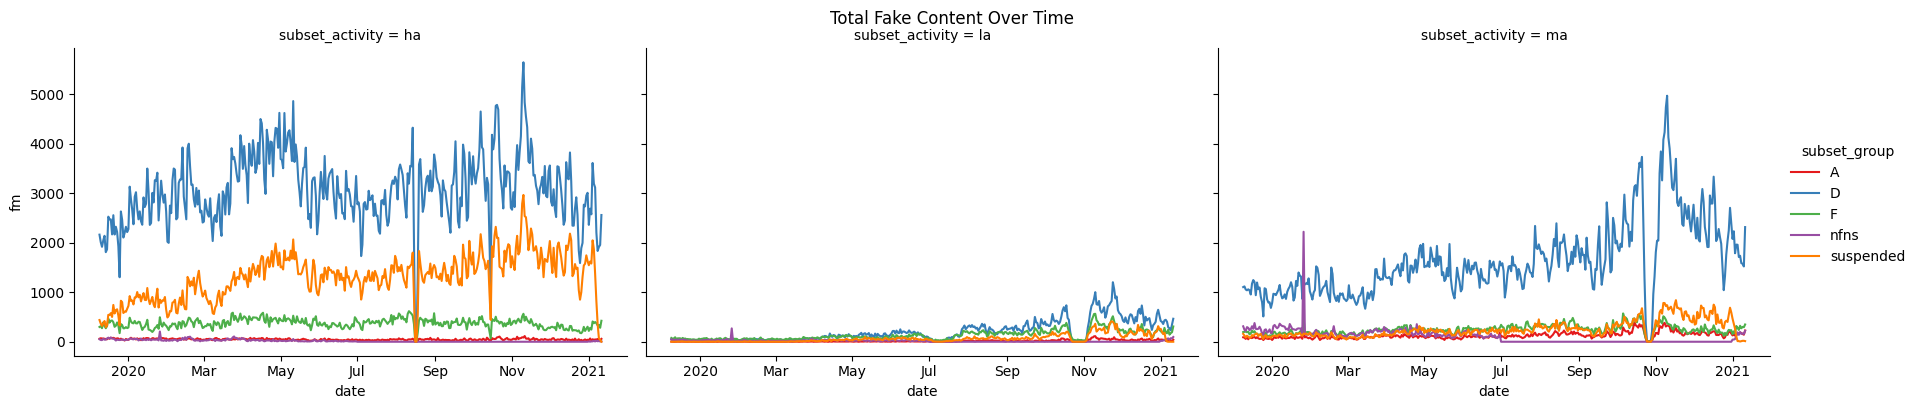

In [4]:
a = sns.relplot(desm_pre, x='date', y='fm', col='subset_activity', kind='line', hue='subset_group', palette='Set1', height=4, aspect=1.5)
for ax in a.axes.flatten():
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.suptitle('Total Fake Content Over Time', y=1.01)
plt.show()

In [5]:
rolling_desm = desm.loc[desm['treated'] == False].drop(columns='treated').set_index('date').groupby(['subsets', 'subset_group', 'subset_activity']).rolling(window=7).mean().reset_index()

I reduced some of the periodicity in the data (either from unobserved components of users' behavior or from the way the data was collected) by using rolling averages with a one-week window.

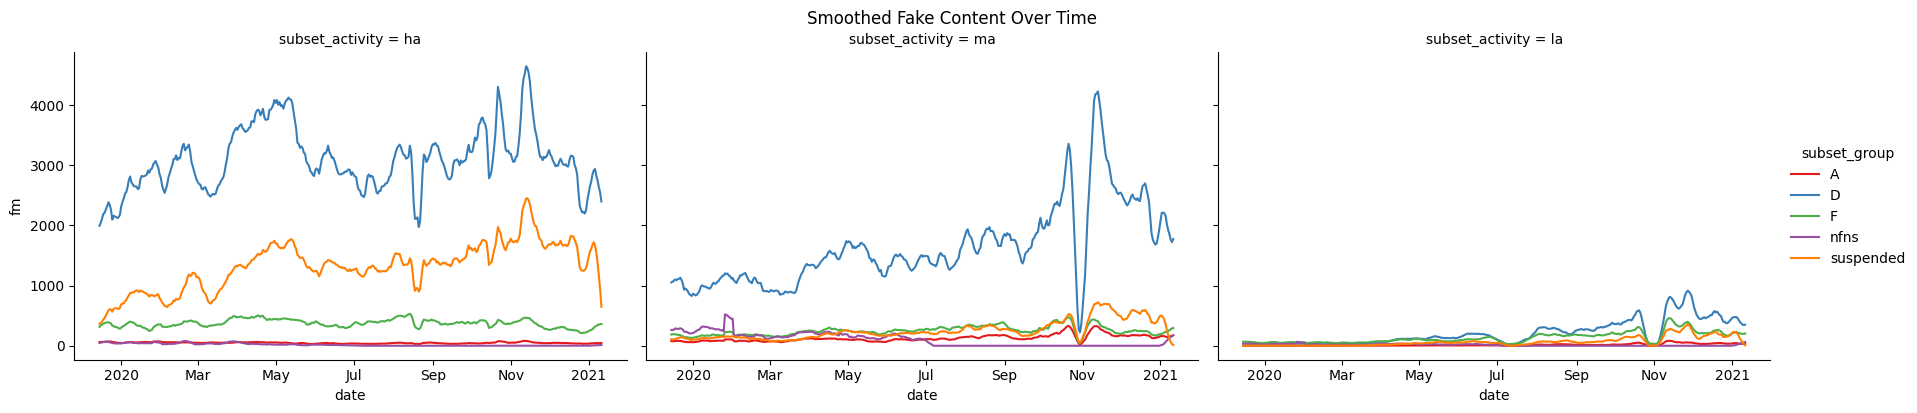

In [6]:
b = sns.relplot(rolling_desm, x='date', y='fm', col='subset_activity', kind='line', hue='subset_group', palette='Set1', height=4, aspect=1.5, col_order=['ha', 'ma', 'la'])
for ax in b.axes.flatten():
    ax.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))
plt.suptitle("Smoothed Fake Content Over Time", y=1.02)
plt.show()

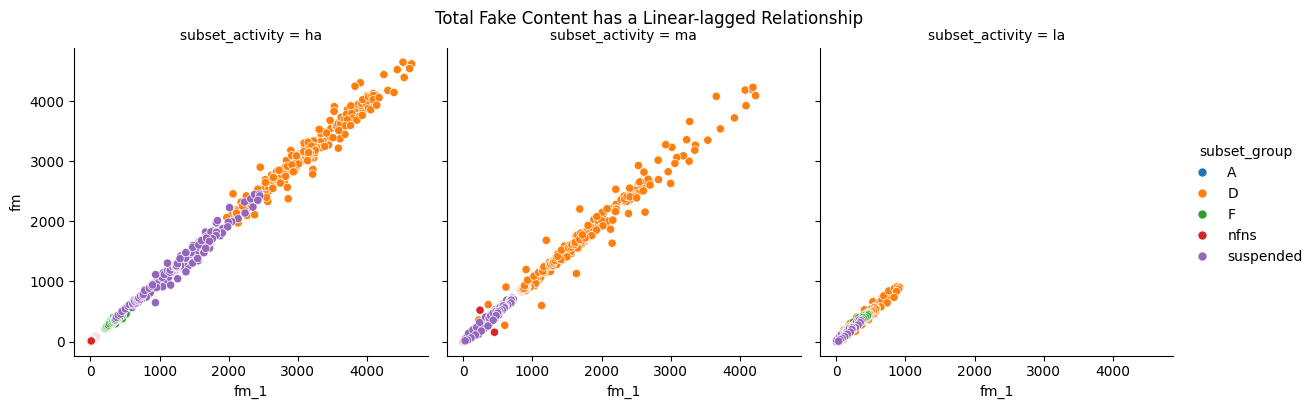

In [7]:
sns.relplot(data=rolling_desm, x='fm_1', y='fm', col='subset_activity', kind='scatter', col_wrap=3, col_order=['ha', 'ma', 'la'], height=4, aspect=1, hue='subset_group')
plt.suptitle('Total Fake Content has a Linear-lagged Relationship', y=1.01)
plt.show()

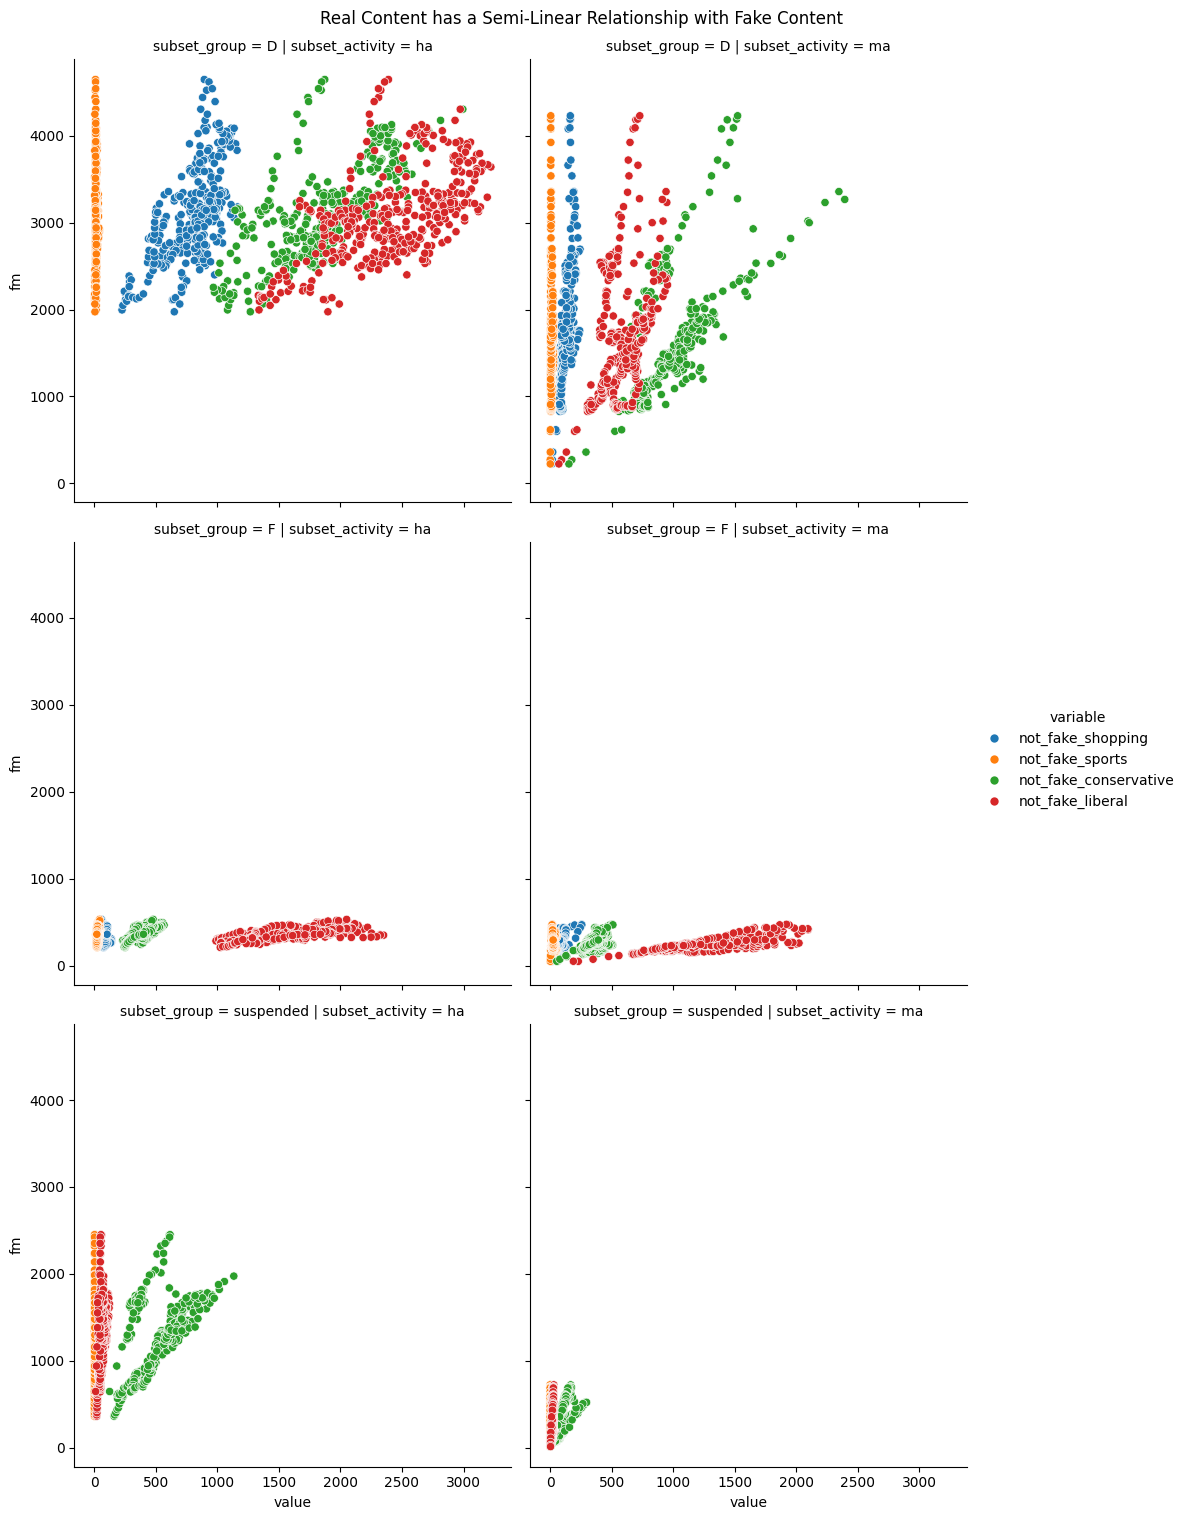

In [8]:
rd_x = rolling_desm.melt(id_vars=['date', 'subset_group', 'subset_activity', 'fm'], value_vars=['not_fake_shopping', 'not_fake_sports', 'not_fake_conservative', 'not_fake_liberal'])
rd_x = rd_x.loc[(rd_x['subset_group'].isin(['D', 'F', 'suspended'])) & (rd_x['subset_activity'].isin(['ha', 'ma']))]
sns.relplot(data=rd_x, x='value', y='fm', hue='variable', col='subset_activity', row='subset_group', kind='scatter')
plt.suptitle('Real Content has a Semi-Linear Relationship with Fake Content', y=1.01)
plt.show()

not_fake_liberal and not_fake_conservative have a linear relationship with fake content in some cases, which indicates group and activity levels are important in modeling

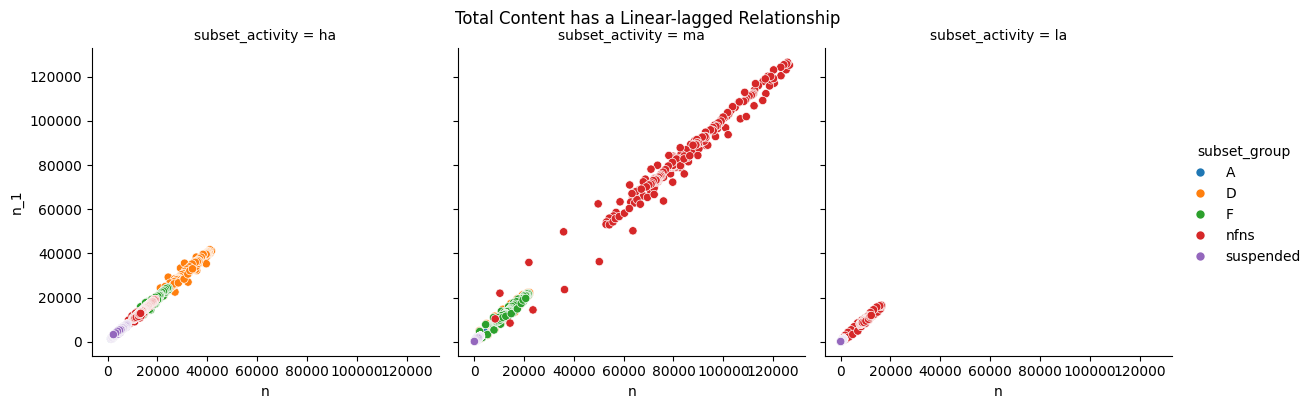

In [9]:
sns.relplot(rolling_desm, x='n', y='n_1', col='subset_activity', hue='subset_group', kind='scatter', col_wrap=3, col_order=['ha', 'ma', 'la'], height=4, aspect=1)
plt.suptitle('Total Content has a Linear-lagged Relationship', y=1.01)
plt.show()

The structural relationships between the different variables are mostly linear and positive.

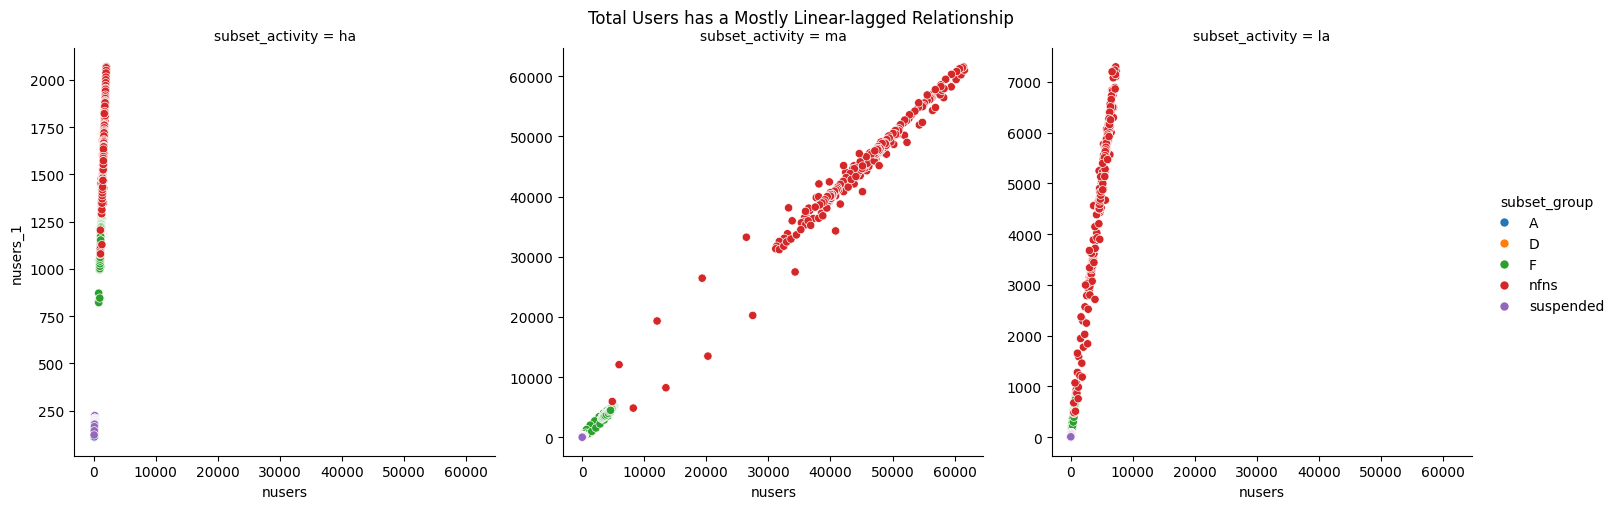

In [10]:
sns.relplot(data=rolling_desm, x='nusers', y='nusers_1', hue='subset_group', col='subset_activity', facet_kws={'sharey': False}, col_order=['ha', 'ma', 'la'])
plt.suptitle('Total Users has a Mostly Linear-lagged Relationship', y=1.01)
plt.show()

In order to use time-series forecasting, I need to ensure that my data is stationary. Columns that aren't stationary will be differenced to be compatible with my model.

In [11]:
from statsmodels.tsa.stattools import adfuller

In [12]:
X = ['not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports']
Y = ['fm']
Z = ['n', 'nusers']
all_vars = X + Y + Z
pdf = desm_pre.copy()[all_vars + ['subset_group', 'subset_activity', 'date']].loc[desm_pre['date'] > datetime(2019, 12, 18)]
pdf.reset_index(inplace=True, drop=True)
pdf.set_index(['date', 'subset_group', 'subset_activity'], inplace=True)

In [13]:
def adf_test(col):
    result = adfuller(col.dropna())
    return result[1] < 0.05
for var in all_vars:
    if adf_test(pdf[var]):
        print(f'{var} is stationary')
    else:
        print(f'{var} is not stationary')

not_fake_conservative is stationary
not_fake_liberal is stationary
not_fake_shopping is stationary
not_fake_sports is stationary
fm is stationary
n is stationary
nusers is stationary


All of the variables are stationary.

### Modeling Suspended Users

In [ ]:
from statsmodels.tsa.api import VAR

suspended = pdf.loc[(pdf.index.get_level_values(1) == 'suspended') & (pdf.index.get_level_values(0) < datetime(2021, 1, 6))]

In [15]:
s_nusers_wide = suspended.reset_index().pivot(index='date', columns='subset_activity', values='nusers')
s_nusers_wide.index = pd.to_datetime(s_nusers_wide.index)
for col in s_nusers_wide.columns:
    s_nusers_wide[col] = np.sqrt(s_nusers_wide[col])
model = VAR(s_nusers_wide, freq='D')
lag_selection = model.select_order(maxlags=10)
lag_selection.summary()

,AIC,BIC,FPE,HQIC
0,2.896,2.928,18.11,2.909
1,-1.724,-1.598,0.1784,-1.674
2,-1.922,-1.701,0.1464,-1.834
3,-2.026,-1.711*,0.1319,-1.901*
4,-2.025,-1.616,0.1320,-1.862
5,-2.042,-1.539,0.1298,-1.842
6,-2.077,-1.479,0.1253,-1.840
7,-2.110*,-1.418,0.1213*,-1.835
8,-2.088,-1.301,0.1240,-1.775
9,-2.054,-1.173,0.1283,-1.705


A 3 day lag seems best. We start the prediction range earlier than needed to allow the predictions to adjust to the lag appropriately.

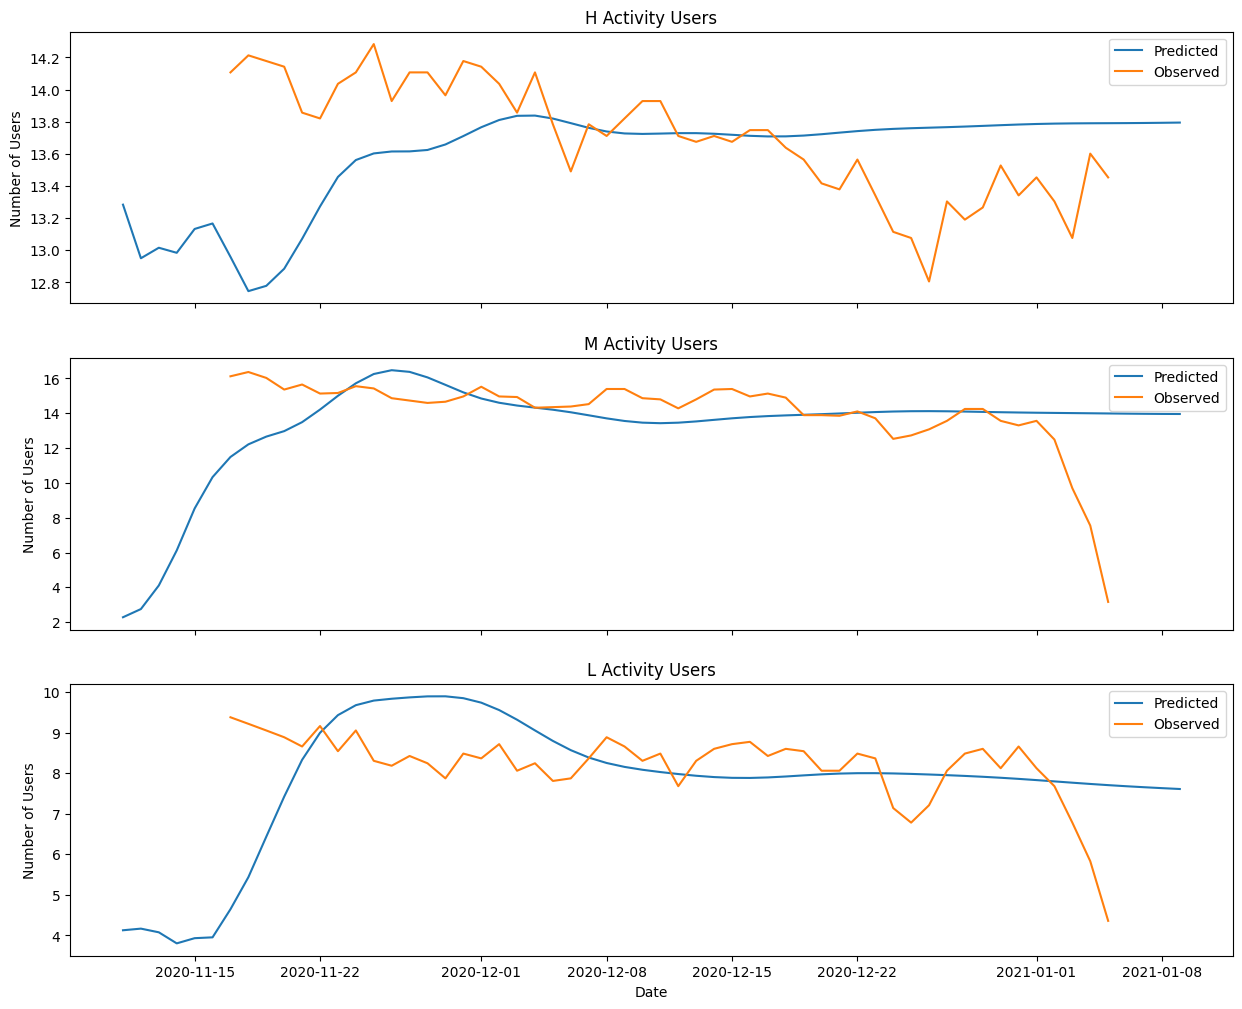

In [20]:
result = model.fit(7)
test_predictions = pd.DataFrame(result.forecast(s_nusers_wide.values[-50:], steps=60), columns=['pred_ha', 'pred_la', 'pred_ma'])
preds_real = s_nusers_wide.iloc[-50:]
test_predictions.index = pd.date_range('2020-11-11', periods=60)
combined = test_predictions.join(preds_real)

fig, ax = plt.subplots(3, 1, figsize=(15, 12))
for i, col in enumerate(['ha', 'ma', 'la']):
    sns.lineplot(data=combined, x=combined.index, y=f'pred_{col}', ax=ax[i], label='Predicted')
    sns.lineplot(data=combined, x=combined.index, y=col, ax=ax[i], label='Observed')
    ax[i].set_title(f'{col.upper()[0]} Activity Users')
    ax[i].set_ylabel('Number of Users')
    if i != 2:
        ax[i].set_xticklabels([])
        ax[i].set_xlabel('')
ax[2].set_xlabel('Date')
plt.show()

The fit seems appropriate for the data. Now I can construct the first part of the synthetic control.

In [134]:
synthetic = pd.DataFrame(result.forecast(test_predictions.values[-7:], steps=150))
synthetic.columns = ['sus_ha_nusers', 'sus_ma_nusers', 'sus_la_nusers']

In [135]:
suspended_data = pdf.loc[pdf.index.get_level_values(1) == 'suspended', ['nusers', 'n', 'fm', 'not_fake_conservative', 'not_fake_liberal', 'not_fake_shopping', 'not_fake_sports']].reset_index()

Using the predicted numbers of users, I will now predict values for other features. These predictions will provide more depth for the final model of all users' behavior. Since 'not fake sports' has a relatively low correlation with the target variable, I will not use it in the final model, but all other features will be used.

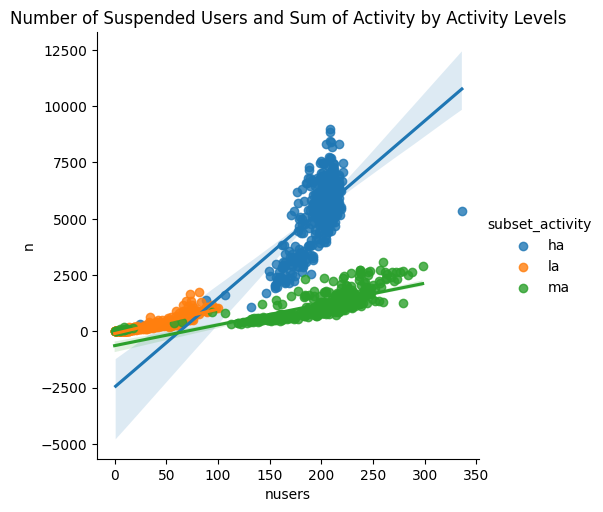

In [78]:
sns.lmplot(x='nusers', y='n', hue='subset_activity', data=suspended_data)
plt.title('Number of Suspended Users and Sum of Activity by Activity Levels')
plt.show()

It seems like low- and moderate-activity users have very similar slopes, but high-activity users have a steeper, curved slope.

In [129]:
from sklearn.linear_model import BayesianRidge
from sklearn.model_selection import train_test_split, GridSearchCV

suspended_subset = suspended_data.loc[(suspended_data['date'] >= datetime(2020, 1, 1)) & (suspended_data['date'] <= datetime(2021, 1, 1))] # select one-year period close to (not including) onset of treatment
suspended_subset['high_activity'] = (suspended_subset['subset_activity'] == 'ha').astype(int) # create binary variable for high activity
X = suspended_subset[['high_activity', 'nusers']]
Y = suspended_subset['n']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=25)

model = BayesianRidge(lambda_2=1e-3, alpha_1=1e-3, tol=1e-4, alpha_2=5e-5)
params = {
    'lambda_1': np.linspace(1e-10, 6e-10, 7),
}
grid_search = GridSearchCV(model, params, cv=4)
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

In [132]:
print(f"Training score: {best_model.score(X_train, Y_train)}, Test score: {best_model.score(X_test, Y_test)}")

Training score: 0.8763366599345839, Test score: 0.8980982570396228


Now I can use this model to predict total content for suspended users using my predictions for number of users.

In [144]:
def suspended_n_prediction(activity):
    nusers = synthetic[[f'sus_{activity}_nusers']]
    nusers.columns = ['nusers']
    if activity == 'ha':
        high_activity = 1
    else:
        high_activity = 0
    nusers['high_activity'] = high_activity
    nusers = nusers.reindex(columns=['high_activity', 'nusers'])
    return best_model.predict(nusers)

synthetic['sus_ha_n'] = suspended_n_prediction('ha')
synthetic['sus_ma_n'] = suspended_n_prediction('ma')
synthetic['sus_la_n'] = suspended_n_prediction('la')

### Modeling Other Users

In [145]:
from sklearn.ensemble import RandomForestRegressor

wide_table_all = pd.DataFrame(pdf.stack().reset_index()).pivot_table(
    index='date',
    columns=['subset_group', 'subset_activity', 'level_3'],
    values=0
)
wide_table_all.columns = ['_'.join(col).strip() for col in wide_table_all.columns.values]
wide_table_all

,A_ha_fm,A_ha_n,A_ha_not_fake_conservative,A_ha_not_fake_liberal,A_ha_not_fake_shopping,A_ha_not_fake_sports,A_ha_nusers,A_la_fm,A_la_n,A_la_not_fake_conservative,...,suspended_la_not_fake_shopping,suspended_la_not_fake_sports,suspended_la_nusers,suspended_ma_fm,suspended_ma_n,suspended_ma_not_fake_conservative,suspended_ma_not_fake_liberal,suspended_ma_not_fake_shopping,suspended_ma_not_fake_sports,suspended_ma_nusers
date,,,,,,,,,,,,,,,,,,,,,
2019-12-19,73.0,2030.0,188.0,164.0,0.0,12.0,164.0,3.0,65.0,8.0,...,0.0,0.0,7.0,162.0,738.0,102.0,6.0,1.0,0.0,170.0
2019-12-20,79.0,1739.0,138.0,125.0,6.0,11.0,158.0,0.0,47.0,4.0,...,0.0,0.0,10.0,167.0,627.0,51.0,7.0,2.0,1.0,163.0
2019-12-21,69.0,1574.0,96.0,130.0,2.0,3.0,163.0,1.0,48.0,4.0,...,0.0,0.0,7.0,114.0,498.0,56.0,3.0,0.0,0.0,150.0
2019-12-22,54.0,1503.0,100.0,110.0,3.0,8.0,157.0,0.0,44.0,1.0,...,0.0,0.0,10.0,137.0,577.0,38.0,11.0,0.0,0.0,140.0
2019-12-23,69.0,1821.0,117.0,165.0,2.0,11.0,162.0,2.0,52.0,7.0,...,0.0,0.0,8.0,161.0,564.0,46.0,2.0,0.0,0.0,149.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-01-07,45.0,2333.0,63.0,143.0,6.0,8.0,168.0,33.0,349.0,10.0,...,0.0,0.0,0.0,5.0,114.0,5.0,5.0,0.0,0.0,11.0
2021-01-08,55.0,2560.0,74.0,167.0,11.0,7.0,162.0,42.0,402.0,16.0,...,0.0,0.0,0.0,12.0,63.0,4.0,2.0,0.0,0.0,9.0
2021-01-09,32.0,1811.0,58.0,117.0,3.0,4.0,152.0,28.0,345.0,17.0,...,0.0,0.0,0.0,19.0,174.0,9.0,6.0,1.0,0.0,9.0


## Sources
McCabe, S.D., Ferrari, D., Green, J. et al. Post-January 6th deplatforming reduced the reach of misinformation on Twitter. Nature 630, 132–140 (2024). https://doi.org/10.1038/s41586-024-07524-8